In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Cargar el dataset
data = pd.read_csv('data\dataset_wide.csv')
    
# Mostrar las primeras filas del dataset
print(data.head())

          P         D          L          R P_fuzzy_set  P_membership   
0 -0.970808 -0.215349  92.656448 -50.022533   muy lejos      0.951346  \
1  0.003012 -0.891419  62.287528  -9.387762          ok      0.992471   
2 -0.992325 -0.985573  92.725463 -50.001575   muy lejos      0.987209   
3  0.993985  0.037114 -28.348040 -23.619177   muy cerca      0.989975   
4  0.912061 -0.922308 -16.715451 -10.967790   muy cerca      0.853434   

  D_fuzzy_set  D_membership                L_fuzzy_set  L_membership   
0  alejandose      1.000000   muy rápido hacia delante      1.000000  \
1  alejandose      1.000000  rápidamente hacia delante      0.885624   
2  alejandose      1.000000   muy rápido hacia delante      1.000000   
3  sin cambio      0.814429      despacito hacia atrás      0.917402   
4  alejandose      1.000000      muy lento hacia atrás      0.664227   

                      R_fuzzy_set  R_membership   
0  más o menos rápido hacia atrás      0.749437  \
1           muy lento haci

In [3]:
X = data[['P','D','L','R','CAT']]
y = data['FRASE']
z = data[['P_fuzzy_set', 'D_fuzzy_set', 'L_fuzzy_set', 'R_fuzzy_set']].apply(lambda x: ' '.join(x), axis=1)

In [4]:
with open('data\corpus.txt', 'r') as f:
    text = f.read()

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
num_decoder_tokens = len(tokenizer.word_index) + 1

In [11]:
y = tokenizer.texts_to_sequences(y)
z = tokenizer.texts_to_sequences(z)

max_len = max(len(s) for s in y)

y = pad_sequences(y, maxlen=num_decoder_tokens, padding='post', truncating='post')
z = pad_sequences(z, maxlen=num_decoder_tokens, padding='post', truncating='post')

In [12]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = X['CAT'], test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Obtener el índice de las filas de X_train, X_val y X_test
idx_train = X_train.index
idx_val = X_val.index
idx_test = X_test.index

In [13]:
# Dividir z en z_train, z_val y z_test
z_train = z[idx_train]
z_val = z[idx_val]
z_test = z[idx_test]

In [14]:
# Ajusta las columnas numéricas con StandardScaler
scaler_values = StandardScaler()
scaler_values.fit(X_train[['P','D','L','R']])

StandardScaler()

In [15]:
X_train[['P','D','L','R']] = scaler_values.transform(X_train[['P','D','L','R']])
X_val[['P','D','L','R']] = scaler_values.transform(X_val[['P','D','L','R']])
X_test[['P','D','L','R']] = scaler_values.transform(X_test[['P','D','L','R']])

In [16]:
X_train = X_train[['P','D','L','R']].values
X_val = X_val[['P','D','L','R']].values
X_test = X_test[['P','D','L','R']].values

In [17]:
print('tamaño X train_scaled', X_train.shape)
print('tamaño y train', y_train.shape)
print('tamaño z train', z_train.shape)


print('tamaño X val_scaled', X_val.shape)
print('tamaño y val', y_val.shape)
print('tamaño z val_scaled', z_val.shape)

print('tamaño X test_scaled', X_test.shape)
print('tamaño y test', y_test.shape)
print('tamaño z test', z_test.shape)

tamaño X train_scaled (5999, 4)
tamaño y train (5999, 95)
tamaño z train (5999, 95)
tamaño X val_scaled (2000, 4)
tamaño y val (2000, 95)
tamaño z val_scaled (2000, 95)
tamaño X test_scaled (2000, 4)
tamaño y test (2000, 95)
tamaño z test (2000, 95)


In [18]:
import torch
from torch.utils.data import DataLoader, Dataset

# Definir los conjuntos de datos
class MyDataset(Dataset):
    def __init__(self, X, y, z):
        self.X = X
        self.y = y
        self.z = z
    
    def __len__(self):
        return len(self.X)  # Devuelve el tamaño del conjunto de datos
    
    def __getitem__(self, index):
        # Obtener ejemplo y su longitud
        x = self.X[index]
        y = self.y[index]
        z = self.z[index]

        # Convertir a tensores de PyTorch y agregar dimensión adicional
        x = torch.tensor(x).float().unsqueeze(0)  # (1, 1, input_size)
        #y = torch.tensor(y).long().unsqueeze(0)  # (1, 1)
        z = torch.tensor(z).long()  # (1,)

        return x, y, z


In [19]:
X_train.shape,y_train.shape,z_train.shape

((5999, 4), (5999, 95), (5999, 95))

In [20]:
train_ds = MyDataset(X_train, y_train, z_train)
valid_ds = MyDataset(X_val, y_val, z_val)
test_ds  = MyDataset(X_test, y_test, z_test)

In [21]:
# Pytorch utiliza DataLoader para entregar los dataset de a batches
train_dataloader = DataLoader(train_ds, batch_size = 128, shuffle= True)
valid_dataloader = DataLoader(valid_ds, batch_size=128)
test_dataloader = DataLoader(test_ds, batch_size=128)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definir dimensiones de entrada y salida
input_size = 4
hidden_size = 64

# Definir modelo

class seq2seqLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_decoder_tokens, num_layers=1):
        super(seq2seqLSTM, self).__init__()
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder_embedding = nn.Embedding(num_decoder_tokens, 128)
        self.decoder_lstm = nn.LSTM(128, hidden_size, num_layers=1, batch_first=True)
        self.linear_layer = nn.Linear(hidden_size, num_decoder_tokens)

    def forward(self, inputs, dec_inputs):
        enc_output, (state_h, state_c) = self.encoder_lstm(inputs)
        embedding = self.decoder_embedding(dec_inputs)
        decoder_output, _ = self.decoder_lstm(embedding, (state_h, state_c))
        decoder_output = decoder_output.reshape(-1, decoder_output.shape[2])
        linear_output = self.linear_layer(decoder_output)
        # Remodela para que tenga el mismo número de pasos de tiempo que dec_inputs
        linear_output = linear_output.reshape(dec_inputs.shape[0], dec_inputs.shape[1], -1)
        return linear_output



model = seq2seqLSTM(input_size, hidden_size, num_decoder_tokens)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

seq2seqLSTM(
  (encoder_lstm): LSTM(4, 64, batch_first=True)
  (decoder_embedding): Embedding(95, 128)
  (decoder_lstm): LSTM(128, 64, batch_first=True)
  (linear_layer): Linear(in_features=64, out_features=95, bias=True)
)

In [27]:
import matplotlib.pyplot as plt

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Inicializar listas para almacenar los valores de loss y accuracy
train_loss_list = []
val_loss_list = []
accuracy_list = []

# Entrenamiento
num_epochs = 20
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    train_loss = 0
    for i, (inputs, labels, dec_inputs) in enumerate(train_dataloader):
        inputs = inputs.to(device)  # Mover inputs a GPU
        labels = labels.to(device)  # Mover labels a GPU
        dec_inputs = dec_inputs.to(device)  # Mover dec_inputs a GPU
        
        optimizer.zero_grad()
        outputs = model(inputs, dec_inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss)
    
    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels, dec_inputs) in enumerate(valid_dataloader):
            inputs = inputs.to(device)  # Mover inputs a GPU
            labels = labels.to(device)  # Mover labels a GPU
            dec_inputs = dec_inputs.to(device)  # Mover dec_inputs a GPU            
            outputs = model(inputs, dec_inputs)
            
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) * labels.size(1)
            correct += (predicted == labels).sum().item()
    val_loss /= len(valid_dataloader)
    val_loss_list.append(val_loss)
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch 1/20, Train Loss: 3.5492, Validation Loss: 2.3132, Accuracy: 49.17%
Epoch 2/20, Train Loss: 1.7128, Validation Loss: 1.4070, Accuracy: 69.60%
Epoch 3/20, Train Loss: 1.3208, Validation Loss: 1.2779, Accuracy: 70.65%
Epoch 4/20, Train Loss: 1.2489, Validation Loss: 1.2391, Accuracy: 71.41%
Epoch 5/20, Train Loss: 1.2190, Validation Loss: 1.2138, Accuracy: 72.07%
Epoch 6/20, Train Loss: 1.1971, Validation Loss: 1.1928, Accuracy: 72.32%
Epoch 7/20, Train Loss: 1.1780, Validation Loss: 1.1760, Accuracy: 72.39%
Epoch 8/20, Train Loss: 1.1608, Validation Loss: 1.1588, Accuracy: 72.62%
Epoch 9/20, Train Loss: 1.1449, Validation Loss: 1.1463, Accuracy: 72.98%
Epoch 10/20, Train Loss: 1.1301, Validation Loss: 1.1297, Accuracy: 73.38%
Epoch 11/20, Train Loss: 1.1156, Validation Loss: 1.1145, Accuracy: 73.46%
Epoch 12/20, Train Loss: 1.1010, Validation Loss: 1.1014, Accuracy: 73.74%
Epoch 13/20, Train Loss: 1.0881, Validation Loss: 1.0885, Accuracy: 73.99%
Epoch 14/20, Train Loss: 1.0742, V

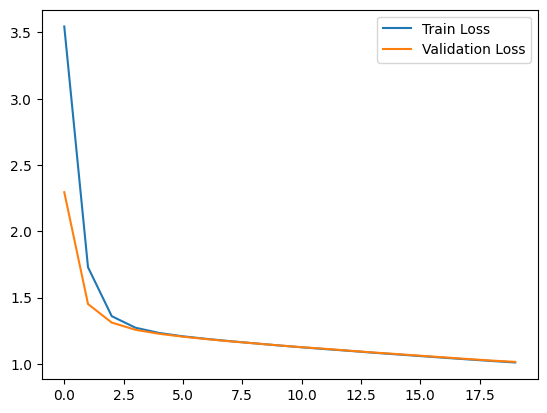

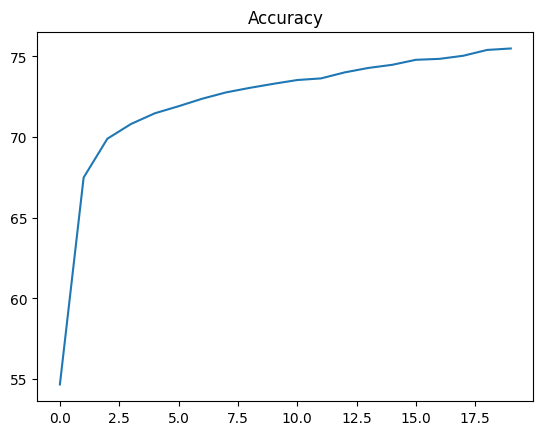

In [24]:
# Graficar loss y accuracy
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(accuracy_list)
plt.title('Accuracy')
plt.show()

In [74]:
def predictions(preds):
    preds_words = []
    for i in range(preds.shape[0]):
        preds_row = preds[i]
        preds_row_words = []
        for idx in preds_row:
            if idx in tokenizer.index_word:
                preds_row_words.append(tokenizer.index_word[idx])
        preds_words.append(preds_row_words)

    return preds_words


In [23]:
frasesnlg = predictions(predicted.numpy())
print(frasesnlg)

[['cuando', 'estés', 'muy', 'cerca', 'a', 'la', 'pared', 'pero', 'ni', 'te', 'alejas', 'más', 'ni', 'te', 'alejas', 'gira', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'atrás', 'hacia', 'atrás', 'y', 'gira', 'tu', 'rueda', 'derecha', 'atrás', 'hacia', 'atrás'], ['cuando', 'estés', 'muy', 'cerca', 'a', 'la', 'pared', 'pero', 'ni', 'te', 'alejas', 'más', 'ni', 'te', 'alejas', 'de', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'despacito', 'hacia', 'atrás', 'y', 'gira', 'tu', 'rueda', 'derecha', 'atrás', 'hacia', 'atrás'], ['cuando', 'estés', 'muy', 'lejos', 'de', 'la', 'pared', 'y', 'te', 'estás', 'alejando', 'aun', 'más', 'de', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'muy', 'rápido', 'hacia', 'delante', 'y', 'gira', 'tu', 'rueda', 'derecha', 'más', 'menos', 'menos', 'rápido', 'hacia', 'atrás'], ['cuando', 'estés', 'a', 'la', 'distancia', 'requerida', 'pero', 'te', 'estás', 'acercando', 'a', 'la', 'pared', 'gira', 'tu', 'rueda', 'izquierda', 'muy', 'cerca', 'hacia', 'atrás', 'y', 'gir

In [24]:
def predict_eval(model,test_dataloader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels, dec_inputs) in enumerate(test_dataloader):
            outputs = model(inputs, dec_inputs)
            loss = criterion(outputs, labels.long())
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) * labels.size(1)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_dataloader)
    accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return predicted.numpy()

In [57]:
preds = predict_eval(model,test_dataloader,criterion)

Test Loss: 0.3791, Accuracy: 96.26%


In [58]:
frasestest = predictions(preds)
for i in range(len(frasestest)-1):
    print(frasestest[i])

['cuando', 'estés', 'muy', 'lejos', 'de', 'la', 'pared', 'pero', 'te', 'estás', 'acercando', 'a', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'rápidamente', 'hacia', 'delante', 'y', 'gira', 'tu', 'rueda', 'derecha', 'muy', 'lento', 'hacia', 'atrás']
['cuando', 'estés', 'cerca', 'a', 'la', 'pared', 'pero', 'te', 'estás', 'alejando', 'de', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'izquierda', 'lento', 'hacia', 'delante', 'y', 'gira', 'tu', 'rueda', 'derecha', 'medio', 'más', 'hacia', 'delante']
['cuando', 'estés', 'muy', 'lejos', 'de', 'la', 'pared', 'pero', 'ni', 'te', 'alejas', 'más', 'ni', 'te', 'acercas', 'a', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'bastante', 'rápido', 'hacia', 'gira', 'y', 'gira', 'tu', 'rueda', 'derecha', 'despacito', 'hacia', 'atrás']
['cuando', 'estés', 'a', 'la', 'distancia', 'requerida', 'y', 'ni', 'te', 'alejas', 'ni', 'te', 'acercas', 'a', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'despacito', 'hacia', 'delante', 'y', 'gira', 'tu', 'rueda', 'derech

In [59]:
torch.save(model.state_dict(), 'Modelos\pytorch_lim_vocab\seq2seqLSTM_model.pt')

In [66]:
model.eval()
test_in = torch.tensor(X_test[0].reshape(1,1,4)).float()
dec_test_in = torch.tensor(z_test[0]).long().unsqueeze(0)

In [67]:
test_in.shape, dec_test_in.shape

(torch.Size([1, 1, 4]), torch.Size([1, 41]))

In [73]:
# Hacer predicciones con el modelo cargado
with torch.no_grad():
    predictions = model(test_in, dec_test_in)
    _, predicts = torch.max(predictions.data, 1)
    

# Imprimir las predicciones
print(predicts)

tensor([[10, 11,  7,  8, 34, 35, 20,  5, 21, 29, 18,  8, 16,  1,  2,  3, 12, 32,
          4, 14,  6,  1,  2,  3, 13, 15, 26,  4,  9,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0]])


In [75]:
predicciones_finales = predictions(predicts.numpy())

In [76]:
predicciones_finales

[['cuando',
  'estés',
  'a',
  'la',
  'distancia',
  'requerida',
  'pero',
  'te',
  'estás',
  'alejando',
  'de',
  'la',
  'pared',
  'gira',
  'tu',
  'rueda',
  'izquierda',
  'rápidamente',
  'hacia',
  'delante',
  'y',
  'gira',
  'tu',
  'rueda',
  'derecha',
  'muy',
  'lento',
  'hacia',
  'atrás']]